create V with N = 316251 states
t = 50 0.5349 sec for 22100 states
t = 49 0.5783 sec for 20825 states
t = 48 0.5226 sec for 19600 states
t = 47 0.4737 sec for 18424 states
t = 46 0.4399 sec for 17296 states
t = 45 0.4209 sec for 16215 states
t = 44 0.379 sec for 15180 states
t = 43 0.3935 sec for 14190 states
t = 42 0.3623 sec for 13244 states
t = 41 0.3386 sec for 12341 states
t = 40 0.3204 sec for 11480 states
t = 39 0.267 sec for 10660 states
t = 38 0.2585 sec for 9880 states
t = 37 0.253 sec for 9139 states
t = 36 0.2117 sec for 8436 states
t = 35 0.1882 sec for 7770 states
t = 34 0.1865 sec for 7140 states
t = 33 0.1681 sec for 6545 states
t = 32 0.1496 sec for 5984 states
t = 31 0.1238 sec for 5456 states
t = 30 0.1298 sec for 4960 states
t = 29 0.1099 sec for 4495 states
t = 28 0.1089 sec for 4060 states
t = 27 0.0904 sec for 3654 states
t = 26 0.0824 sec for 3276 states
t = 25 0.075 sec for 2925 states
t = 24 0.0654 sec for 2600 states
t = 23 0.0638 sec for 2300 states
t = 22 0

100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


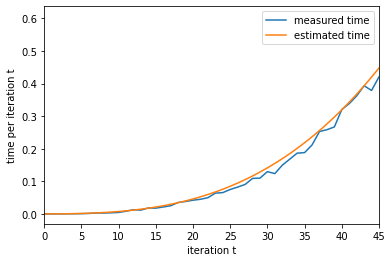

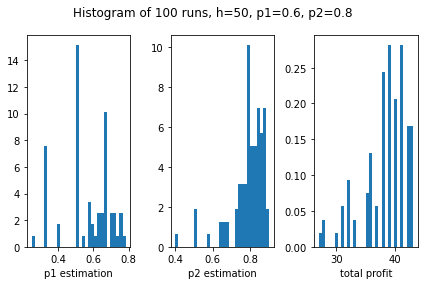

In [223]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

def p(n,w): # calculate expected probability from drawings and payoffs for a machine
    return (w+1)/(n+2)

def get_V(h):
    t_array = np.zeros(h)
    V = np.zeros([h+1,h+1,h+1,h+1])
    print('create V with N =',int((h**4+10*h**3+35*h**2+50*h+24)/24),'states')
    t1 = time()
    counts = np.zeros(h)
    count = 0
    for n1 in range(h): # look at all states at a certain time
        n2 = h-1-n1 # (n1,n2) = (10,0),(9,1),(8,2),...,(9,0),(8,1),(7,2),...,(8,0),(7,1),...,...(0,1),(1,0),(0,0) --> state (0,0) can maybe cause problems       
        for w1 in range(n1+1):
            for w2 in range(n2+1):
                count += 1
                V[n1,w1,n2,w2] = np.max([p(n1,w1),p(n2,w2)])
    t2 = time()
    print('t =',h,round(t2-t1,4),'sec for',count,'states')
    t_array[h-1] = t2-t1

    # for t in tqdm(range(h)[::-1]): # look at all time points 
    for t in range(h)[::-1]: # look at all time points 
        count = 0
        t1 = time()
        for n1 in range(t+1): # look at all states at a certain time
            n2 = t-1-n1 # (n1,n2) = (10,0),(9,1),(8,2),...,(9,0),(8,1),(7,2),...,(8,0),(7,1),...,...(0,1),(1,0),(0,0) --> state (0,0) can maybe cause problems       
            for w1 in range(n1+1):
                for w2 in range(n2+1):
                    count += 1
                    value1 = p(n1,w1)*(1+V[n1+1,w1+1,n2,w2])+(1-p(n1,w1))*V[n1+1,w1,n2,w2]
                    value2 = p(n2,w2)*(1+V[n1,w1,n2+1,w2+1])+(1-p(n2,w2))*V[n1,w1,n2+1,w2]
                    V[n1,w1,n2,w2] = np.max([value1,value2],axis=0)
        t2 = time()
        print('t =',t,round(t2-t1,4),'sec for',count,'states')
        t_array[h-1-t] = t2-t1
        counts[h-1-t] = count
    return V,t_array,counts

def two_armed_bandit(V,p1,p2):
    h = np.where(V!=0)[0][-1]+1
    # initialize values before drawing
    n1,w1,n2,w2 = 0,0,0,0 # initialize states
    states = np.zeros([h+1,4]) # state matrix

    for i in range(1,h+1): # first state is all zeros, from there fill in the matrix
        value1 = p(n1,w1)*(1+V[n1+1,w1+1,n2,w2])+(1-p(n1,w1))*V[n1+1,w1,n2,w2]
        value2 = p(n2,w2)*(1+V[n1,w1,n2+1,w2+1])+(1-p(n2,w2))*V[n1,w1,n2+1,w2]
        machine =  np.argmax([value1,value2]) + 1
        if machine==1:
            n1 += 1
            if np.random.rand()<p1:
                w1 += 1
        else:
            n2 += 1
            if np.random.rand()<p2:
                w2 += 1
        states[i] = n1,w1,n2,w2
        w = w1+w2
    return states,w

h = 50
p1,p2 = 0.6,0.8 # probability that machine pays off 1 

V,t,counts = get_V(h)

if h>20: # time plot of iterations
    t2 = np.linspace(0,h,len(t[:-1]))
    fig,ax = plt.subplots()
    ax.plot(np.arange(h)[::-1],t,label='measured time')
    ax.plot(t2,np.mean(t[:-int(h/2)]/counts[:-int(h/2)])*(1/6*t2**3+t2**2+11/6*t2+1),label='estimated time')
    ax.set_xlabel('iteration t')
    ax.set_ylabel('time per iteration t')
    ax.set_xticks(np.arange(0,h,int(h/10)))
    ax.set_xlim([0,h-5])
    ax.legend()

if h<10: # print all V values
    print('All states:')
    for i in np.transpose(np.where(V!=0)):
        print('({}{}{}{})={:.2f}'.format(i[0],i[1],i[2],i[3],np.round(V[i[0],i[1],i[2],i[3]],2)),end=" ")

if h>30: # plot estimated p1,p2 and profit
    runs = 100
    w_array = np.zeros(runs)
    all_states = np.zeros([runs,4])
    for i in tqdm(range(runs)):
        states,w_array[i] = two_armed_bandit(V,p1,p2)
        all_states[i] = states[-1]
    p1_estimates = all_states[:,1]/np.where(all_states[:,0]==0,1,all_states[:,0])
    p2_estimates = all_states[:,3]/np.where(all_states[:,2]==0,1,all_states[:,2])

    fig,ax = plt.subplots(ncols=3)    
    ax[0].hist(p1_estimates[np.where(p1_estimates!=0)],bins=30,density=True)
    ax[0].set_xlabel('p1 estimation')
    ax[1].hist(p2_estimates[np.where(p2_estimates!=0)],bins=30,density=True)
    ax[1].set_xlabel('p2 estimation')
    ax[2].hist(w_array,bins=30,density=True)
    ax[2].set_xlabel('total profit')
    fig.suptitle('Histogram of {} runs, h={}, p1={}, p2={}'.format(runs,h,p1,p2))
    fig.tight_layout()
